# Backgrounds in opticam_new

`opticam_new` uses `photutils` to handle two-dimensional image backgrounds. In this notebook, I will demonstrate how to define backgrounds for use with `opticam_new`, as well as explain `opticam_new`'s default behaviour when no background is specified.

## Test Image

First thing's first, let's open an image so we can compute its background. For this example, I'll use one of the images from the Basic Usage tutorial:

In [1]:
from astropy.io import fits
import numpy as np

with fits.open("Data/g-band_image_0.fits") as hdul:
    print(repr(hdul[0].header))
    image = np.array(hdul[0].data)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
FILTER  = 'g       '                                                            
BINNING = '8x8     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:00'                                                 


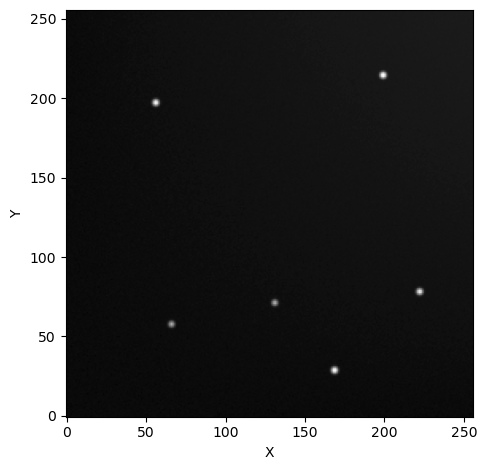

In [10]:
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

## Default Background

`opticam_new`'s default background estimator is largely the same as the default `Background2D()` estimator in `photutils`. The difference between the two is that `opticam_new`'s implementation will automatically set a `box_size` value based on the image binning. We will go through each of the tunable parameters when we implement a custom background estimator, but for now let's take a look at the default background estimator:

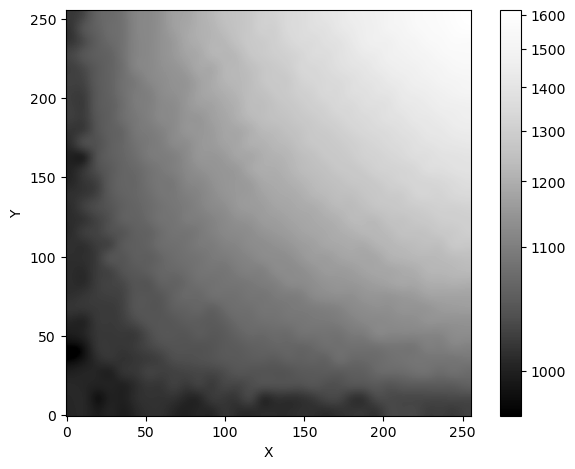

In [3]:
from opticam_new import Background

default_background = Background(box_size=8)  # opticam_new's default box_size is 64 divided by the binning factor
                                             # (in this case 64 / 8 = 8)

bkg_image = default_background(image).background  # compute the background for the image

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(bkg_image, norm=simple_norm(bkg_image, stretch="sqrt"), origin="lower", cmap="Greys_r")

fig.colorbar(im)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

As we can see, the background varies considerably across the image. Let's subtract the background from the images and compare the histograms of pixel values before and after removing the background from the image:

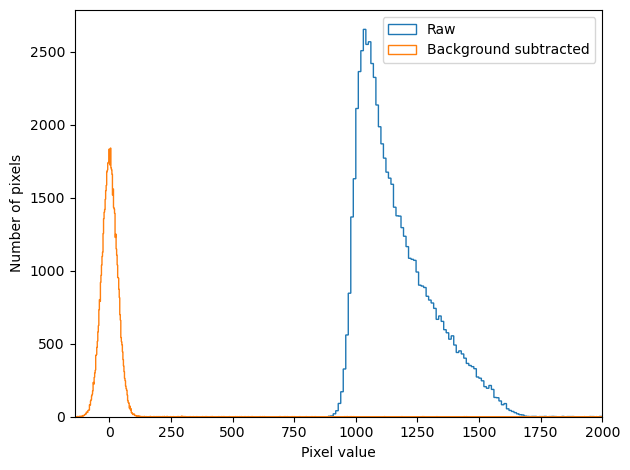

In [4]:
fig, ax = plt.subplots(tight_layout=True)

ax.hist(image.flatten(), bins='auto', histtype="step", label="Raw")
ax.hist((image - bkg_image).flatten(), bins='auto', histtype="step", label="Background subtracted")

ax.set_xlabel("Pixel value")
ax.set_ylabel("Number of pixels")

ax.legend()

ax.set_xlim(np.min(image - bkg_image), 2000)

plt.show()

We can see that the background has been massively reduced. After subtracting the background, the pixel values (ignoring contributions from sources) appear approximately Gaussian distributed about zero.

I hope you would agree that using `opticam_new`'s default background is extremely easy. However, in some cases, we may see better results if we implement a custom background estimator.

## Custom Backgrounds

Let's now define a custom background estimator. Custom background estimators should either inheret from the base `Background` class, or implement a `__call__()` method that takes either a string or a `NumPy` array as input and returns a `Background2D` object. If a string is given, it is the directory path to the image; if it is a `NumPy` array, then it is the image. The `Background` base class implements this `__call__()` method for us for convenience. In this case, we will not inherit from the `Background` base class and will implement the `__call__()` method ourselves:

In [5]:
from photutils.background import Background2D

from opticam_new.helpers import get_data

class CustomBackground:
    
    def __init__(self, box_size, sigma_clip, bkg_estimator, bkgrms_estimator):
        self.box_size = box_size
        self.sigma_clip = sigma_clip
        self.bkg_estimator = bkg_estimator
        self.bkgrms_estimator = bkgrms_estimator
    
    def __call__(self, image):
        
        # if image is a string, it is a path to a fits file
        if isinstance(image, str):
            data = get_data(image)
        # if the image is not a string, it is an array (i.e., the image itself)
        else:
            data = image
        
        return Background2D(data, self.box_size, sigma_clip=self.sigma_clip, bkg_estimator=self.bkg_estimator,
                            bkgrms_estimator=self.bkgrms_estimator)

In this example, I have defined the background object to take four parameters. These parameters are:
- `box_size` : the size of the mesh used to create the background image.
- `sigma_clip` : the sigma clipping function (used to exclude bright pixels from the background). `astropy.stats` provides a sigma clipping routine for clipping global outliers.
- `bkg_estimator` : the algorithm used to estimate the background. `photutils` implements several background estimators, as well as allowing custom estimators to be used.
- `bkgrms_estimator` : the algorithm used to estimate the background RMS. `photutils` implements several background RMS estimators, as well as allowing custom estimators to be used.

In addition to the above parameters, when an instance of this background is called, it takes an `image` parameter. This `image` parameter can either be the directory path to the image or it can be the image itself as a NumPy array. Note: custom backgrounds **must** take a single `image` input and return a `photutils.background.Background2D` object when they are called.

Now, let's use this custom background estimator to compute the background of our above image, using custom functions for the `bkg_estimator` and `bkgrms_estimator` parameters:

In [6]:
from photutils.background import BackgroundBase, BackgroundRMSBase

class BkgEstimator(BackgroundBase):
    """
    Simple background estimator that calculates the median of the (sigma clipped) data.
    """
    
    def calc_background(self, data, axis=None, masked=False):
        
        if self.sigma_clip is not None:
            data = self.sigma_clip(data, axis=axis, masked=False)
        else:
            if isinstance(data, np.ma.MaskedArray):
                data = data.filled(np.nan)
        
        return np.nanmedian(data, axis=axis)


class BkgRMSEstimator(BackgroundRMSBase):
    """
    Simple background RMS estimator that calculates the standard deviation of the (sigma clipped) data.
    """
    
    def calc_background_rms(self, data, axis=None, masked=False):
        if self.sigma_clip is not None:
            data = self.sigma_clip(data, axis=axis, masked=False)
        else:
            if isinstance(data, np.ma.MaskedArray):
                data = data.filled(np.nan)
        
        return np.nanstd(data, axis=axis)

For more information on defining custom background and background RMS estimators, I refer to the excellent `photutils` documentation: https://photutils.readthedocs.io/en/stable/background.html#d-background-and-noise-estimation.

In [7]:
from astropy.stats import SigmaClip

custom_background = CustomBackground(box_size=8, sigma_clip=SigmaClip(sigma=3, maxiters=10), bkg_estimator=BkgEstimator(),
                                    bkgrms_estimator=BkgRMSEstimator())

custom_bkg_image = custom_background(image).background

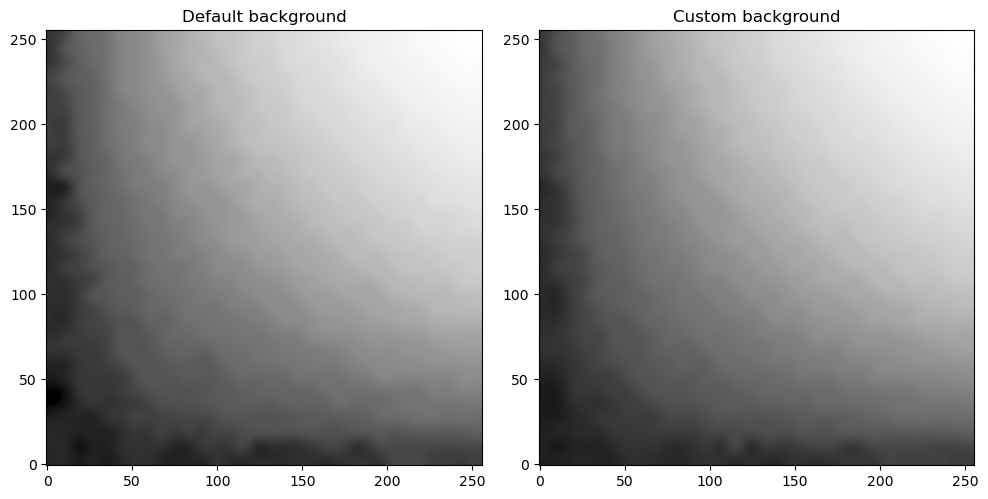

In [8]:
fig, ax = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

im = ax[0].imshow(bkg_image, norm=simple_norm(bkg_image, stretch="sqrt"), origin="lower", cmap="Greys_r")
ax[0].set_title("Default background")

im = ax[1].imshow(custom_bkg_image, norm=simple_norm(bkg_image, stretch="sqrt"), origin="lower", cmap="Greys_r")
ax[1].set_title("Custom background")

plt.show()

As you can see, the two backgrounds are very similar (note that they also share the same normalisation). `opticam_new`'s default background estimator uses the SExtractor algorithm to estimate the background, which is given by `2.5 * median - 1.5 * mean`. However, this algorithm will default to purely the median if `(mean - median) / std > 0.3`. Let's compare the histograms between these two background estimators:

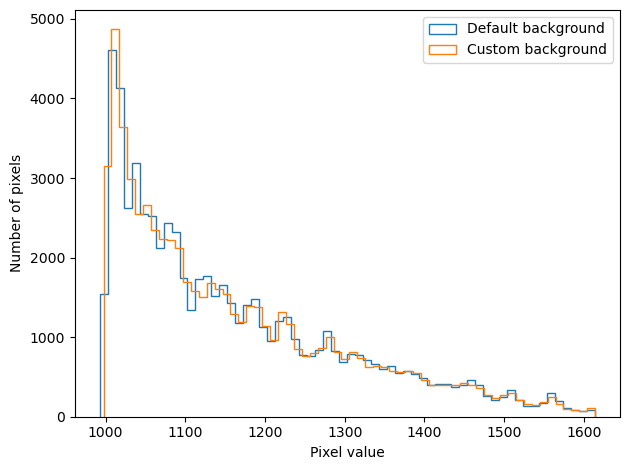

In [9]:
fig, ax = plt.subplots(tight_layout=True)

ax.hist(bkg_image.flatten(), bins='auto', histtype="step", label="Default background")
ax.hist(custom_bkg_image.flatten(), bins='auto', histtype="step", label="Custom background")

ax.set_xlabel("Pixel value")
ax.set_ylabel("Number of pixels")

ax.legend()

plt.show()

As we can see, there are some slight differences between the two estimators, since the SExtractor algorithm is not always the median value.

That concludes the backgrounds tutorial for `opticam_new`! Much of the heavy lifting here is handled by `photutils`, so I'd highly recommend checking out their documentation for more information on the different background estimators available.